In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import LSTM, SpatialDropout1D 
from sklearn.model_selection import train_test_split
import csv
import keras
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import os
#from getcpuinfo import cpuinfo
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import requests
from apscheduler.schedulers.background import BackgroundScheduler
import datetime
from keras import regularizers

Using TensorFlow backend.


In [2]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from apis.getcpuinfonoscaling import cpuinfo 

In [3]:
from sklearn.metrics import accuracy_score

In [4]:
def getTrainedLSTMModel(maxLengthParam):
    
    model = Sequential()
    
    #model.add(SpatialDropout1D(0.3))
    
    model.add(LSTM((50),dropout = 0.3,batch_input_shape = (None,50,1), return_sequences = True))
    
    model.add(Dense(25, activation = 'relu',
                        kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.1)))
    
    model.add(LSTM(25,return_sequences = False))
    
    model.add(Dense(12, activation = 'relu',
                        kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.1)))
    
    model.add(Dropout(rate = 0.3))
    
    model.add(Dense(6, activation = 'relu',
                        kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.1)))
    
    model.add(Dense(3, activation='softmax', kernel_initializer='he_normal'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])
    
    if os.path.isfile("SimpleLSTMV4BestWeights.hdf5"):
        
        #print("Hey")
        
        model.load_weights("SimpleLSTMV4BestWeights.hdf5")
        
        return model
    else:
        
        print("Unable to find trained model")
        
        return -1;
    
    
def getTrained3OuptutModel(maxLengthParam):
    
    model = Sequential()
    #model.add(SpatialDropout1D(0.3))
    model.add(Flatten(batch_input_shape = (None,50,1)))

    model.add(Dense(50, activation = 'relu',
                        kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.1)))

    model.add(Dropout(0.3, noise_shape=None, seed=None))

    model.add(Dense(25, activation = 'relu',
                        kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.1)))

    model.add(Dropout(0.3, noise_shape=None, seed=None))

    #model.add(SpatialDropout1D(0.3))
    model.add(Dense(12,activation = 'relu',
                        kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.1)))

    model.add(Dropout(0.3, noise_shape=None, seed=None))

    model.add(Dense(6,activation = 'relu',
                        kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.1)))

    model.add(Dropout(0.3, noise_shape=None, seed=None))

    model.add(Dense(3, activation='softmax',kernel_initializer='he_normal'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])
    
    if os.path.isfile("3OutputDNNV2BestWeights.hdf5"):
        
        #print("Hey")
        
        model.load_weights("3OutputDNNV2BestWeights.hdf5")
        
        print("Returning Trained Model")
        
        return model
    else:
        
        print("Unable to find trained model")
        
        return -1;
    
def getTrainedRL3OutputDNN(historyParam):
    
    usageInputLayer = keras.layers.Input(shape=(historyParam,1))
    
    flattened_layer = keras.layers.Flatten()(usageInputLayer)
    
    '''fullyConnected_0 = keras.layers.Dense(125, activation = 'relu',
                    kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.1))(flattened_layer)'''
    
    fullyConnected_1 = keras.layers.Dense(50, activation = 'relu',
                    kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.1))(flattened_layer)
    
    #drop1 = keras.layers.Dropout(0.25)(fullyConnected_1)
    
    fullyConnected_2 = keras.layers.Dense(50, activation = 'relu',
                    kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.1))(fullyConnected_1)
    
    #drop2 = keras.layers.Dropout(0.25)(fullyConnected_2)
    
    fullyConnected_3 = keras.layers.Dense(50, activation = 'relu',
                    kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.1))(fullyConnected_2)
    
    fullyConnected_4 = keras.layers.Dense(25, activation = 'relu',
                    kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.1))(fullyConnected_3)
    
    fullyConnected_5 = keras.layers.Dense(12, activation = 'relu',
                    kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.1))(fullyConnected_4)
    
    fullyConnected_6 = keras.layers.Dense(6, activation = 'relu',
                    kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.1))(fullyConnected_5)
    
    softmax_output = keras.layers.Dense(3,activation='softmax',kernel_initializer='he_normal')(fullyConnected_6)
    
    predictionModel = keras.models.Model(inputs=usageInputLayer,outputs=softmax_output)
    
    if os.path.isfile("3OutputRLV4BestWeights.hdf5"):
        
        #print("Hey")
        
        predictionModel.load_weights("3OutputRLV4BestWeights.hdf5")
        
        print("Returning Trained Model")
        
        return predictionModel
    
    else:
        
        print("Unable to find trained model")
        
        return -1;
    
def getTrainedRLLSTM(historyParam):
    
    usageInputLayer = keras.layers.Input(shape=(historyParam,1))
    
    #flattened_layer = keras.layers.Flatten()(usageInputLayer)
    
    LSTM_1 = keras.layers.LSTM((50), return_sequences = True)(usageInputLayer)
    
    full_connect_2 = keras.layers.Dense(25, activation = 'relu',kernel_initializer='he_normal')(LSTM_1)
    
    LSTM_3 = keras.layers.LSTM(25, return_sequences = False)(full_connect_2)
    
    full_connect_3 = keras.layers.Dense(12, activation = 'relu',kernel_initializer='he_normal')(LSTM_3)
    
    full_connect_4 = keras.layers.Dense(6, activation = 'relu',kernel_initializer='he_normal')(full_connect_3)
    
    softmax_output = keras.layers.Dense(3,activation='softmax',kernel_initializer='he_normal')(full_connect_4)
    
    predictionModel = keras.models.Model(inputs=usageInputLayer,outputs=softmax_output)
    
    if os.path.isfile("LSTMV3RLBestWeights.hdf5"):
        
        #print("Hey")
        
        predictionModel.load_weights("LSTMV3RLBestWeights.hdf5")
        
        print("Returning Trained Model")
        
        return predictionModel
    else:
        
        print("Unable to find trained model")
        
        return -1

In [5]:
def appendToList(oldList,newList,maxLength):
    
    #append to the new entries
    #oldList = np.insert(oldList,0,np.array([newList]),axis = 0)
    oldList = np.append(oldList,np.array([newList]),axis = 0)
    #Remove oldest row if there are more than 50 entries
    if(oldList.shape[0]>maxLength):
        oldList = oldList[1:,:]
    #print(oldList)
    return oldList

def getPredictionsForOneTimeStep(model,usageList,maxLengthParam):
    
    currUsageList = cpuinfo()
    
    updatedList = appendToList(usageList,currUsageList,maxLengthParam)
    
    predictions = []
    
    predDict = {0:0,1:1,2:-1}
    
    for i in range(updatedList.shape[1]):
        
        if updatedList.shape[0]==maxLengthParam:
            
            modelOutput = model.predict(np.expand_dims(np.expand_dims(updatedList[:,i],axis = 1),axis = 0))
            
            #print(modelOutput)

            modelPrediction = predDict[np.argmax(modelOutput)]

            predictions.append(modelPrediction)
        
        else:
            
            predictions.append(0)
    
    return predictions, updatedList

#overProvisionedList = 

def getRightOutputs(usageList,minThreshold, maxThreshold):
    
    currList = usageList[0,:]
    print("Current Usage:",currList)
    
    target = []
    
    for i in range(usageList.shape[1]):
        if currList[i] > maxThreshold:# Scale Up
            #print("MaxThres ",maxThreshold," ",currList[i])
            target.append(1)
        elif currList[i] < minThreshold: # Scale Down
            #print("MinThres ",minThreshold," ",currList[i])
            target.append(-1)
        else:
            #print("Same ",currList[i])
            target.append(0)  #Remain same
    
    return target

def getVirtualMachineCPU():
    
    availableVirtualMachineCPU = 10
    
    return availableVirtualMachineCPU

def getPercentagesBasedOnPredictions(predictions, usageArray, minThreshold, maxThreshold):
    
    underProvisionedContainers = [i for i in range(usageArray[0,:].shape[1])  if usageArray[0,i]>maxThreshold]
    
    overProvisionedContainers = [i for i in range(usageArray[0,:].shape[1])  if usageArray[0,i]<minThreshold]
    
    rightlyProvisionedContainers = [i for i in range(usageArray[0,:].shape[1])  if usageArray[0,i]>=minThreshold and usageArray[0,i]<=maxThreshold]
    
    availableVCPU = getVirtualMachineCPU()
    
    VCPUSplit = 0
    
    percentArray = np.zeros(len(predictions))
    
    if len(overProvisionedContainers)>0:
        
        availableVCPU = availableVCPU + len(overProvisionedContainers) * 10
        
        for i in overProvisionedContainers:
            
            percentArray[i] = -10
    
    #if len(rightlyProvisioned)>0:
        #availableVCPU = availableVCPU + len(rightlyProvisioned) * 5
        
    if availableVCPU>0 and len(underProvisionedContainers)>0:
        
        if len(underProvisionedContainers)*10>availableVCPU:
            
            for i in rightlyProvisionedContainers:
                
                percentArray[i] = -5
                
                availableVCPU += 5
                
                if (availableVCPU < len(underProvisionedContainers)*10):
                    
                    break
        
            VCPUSplit = availableVCPU/len(underProvisionedContainers)
            
        else:
            
            VCPUSplit = 10
        
        for i in underProvisionedContainers:
                
                percentArray[i] = VCPUSplit
        
    
    return percentArray
        

def callAPIWithPredictions(predictions,URL):

    headers = {
        'Content-Type': 'application/json',
    }

    data = '{"predictions":['+ ','.join(str(num) for num in predictions) +']}'
    #print(data)
    response = requests.post(URL, headers=headers, data=data)
    

    
class Prediction():
    def __init__(self, model, maxLengthParam,containerCount,minThreshold, maxThreshold):
        self.usageArray = np.empty(shape = (0,containerCount))
        self.correctOutputArray = np.empty(shape = (0,containerCount))
        self.predictionsArray = np.empty(shape = (0,containerCount))
        self.model = model
        self.maxLengthParam = maxLengthParam
        self.minThreshold = minThreshold
        self.maxThreshold = maxThreshold
        self.lastPredictions = [-1, -1, -1, -1]
        self.accuracy_list = []
    
    def generatePredictions(self): 
        predictions,self.usageArray = getPredictionsForOneTimeStep(self.model,self.usageArray,self.maxLengthParam)       
        self.predictionsArray = appendToList(self.predictionsArray, predictions, self.maxLengthParam)
        if (self.usageArray.shape[0]==self.maxLengthParam):
            correctOutputsList = getRightOutputs(self.usageArray,self.minThreshold, self.maxThreshold)
            self.correctOutputArray = appendToList(self.correctOutputArray, correctOutputsList, self.maxLengthParam)
            print("Last expected Outputs: ",correctOutputsList)
            print("Last Predictions: ",self.lastPredictions)
            accuracy = accuracy_score(self.lastPredictions,correctOutputsList)
            print("Last Prediction Accuracy",accuracy)
            self.accuracy_list.append(accuracy)
            print("Current Predictions: ",predictions,"\n")            
            #callAPIWithPredictions(predictions,"http://152.46.19.80:5000/changeVCPU")
            self.lastPredictions = predictions
            
    
# def generatePredictions(model, maxLengthParam,containerCount,minThreshold, maxThreshold):
    
#     usageArray = np.empty(shape = (0,containerCount))
    
#     cnt = 0;
    
#     correctOutputArray = np.empty(shape = (0,containerCount))
    
#     predictionsArray = np.empty(shape = (0,containerCount))
    
#     while cnt<80:
        
#         predictions,usageArray = getPredictionsForOneTimeStep(model,usageArray,maxLengthParam)
        
#         predictionsArray = appendToList(predictionsArray, predictions, maxLengthParam)
        
        
#         if(usageArray.shape[0]==maxLengthParam):
    
#             correctOutputsList = getRightOutputs(usageArray,minThreshold, maxThreshold)

#             correctOutputArray = appendToList(correctOutputArray, correctOutputsList, maxLengthParam)
            
#             print("Predictions: ",predictions)
            
#             print("Expected Outputs: ",correctOutputsList)
            
#             callAPIWithPredictions(predictions,"http://152.46.19.96:5000/changeVCPU")
            
#             print(accuracy_score(predictions,correctOutputsList))
            
#             #percentArray = getPercentagesBasedOnPredictions(predictions,usageArray,minThreshold, maxThreshold)
            
#             #print("Percentage Changes",percentArray)
#             #for i in range(usageArray.shape[1]):

#                 #correctOutputsForTraining = to_categorical(correctOutputs,num_classes = 3)
        
#         cnt+=1

In [12]:
def plot_line_graph(data):
    fig = plt.gcf()
    #fig.set_size_inches(18.5, 10.5)
    t = np.arange(0.01, len(data), 1)
    plt.plot(t, data) 
    # make these tick labels visible
    #plt.setp(ax1.get_xticklabels(), visible=True)
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.show()

In [7]:
LSTMModel = getTrainedLSTMModel(50)
DL3OutputModel = getTrained3OuptutModel(50)
RLLSTMModel = getTrainedRLLSTM(50)
RL3OutputDNNModel = getTrainedRL3OutputDNN(50)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Returning Trained Model
Returning Trained Model
Returning Trained Model


In [8]:
temp = cpuinfo()

In [37]:
temp = cpuinfo()
test = Prediction(RLLSTMModel,50,len(temp),30,70)
for i in range(51):
    test.generatePredictions()

Current Usage: [27.6389309 28.9414025 42.258356  78.0375281]
Last expected Outputs:  [-1, -1, 0, 1]
Last Predictions:  [-1, -1, -1, -1]
Last Prediction Accuracy 0.5
Current Predictions:  [0, 0, 0, 1] 

Current Usage: [33.6113376 28.9414025 42.258356  78.0375281]
Last expected Outputs:  [0, -1, 0, 1]
Last Predictions:  [0, 0, 0, 1]
Last Prediction Accuracy 0.75
Current Predictions:  [0, 0, 0, 1] 



In [38]:
sched = BackgroundScheduler()
sched.add_job(test.generatePredictions, 'interval', seconds=2)
sched.start()
print(datetime.datetime.now())

2019-04-26 17:09:00.316286
Current Usage: [33.6113376 29.0822593 42.258356  78.0375281]
Last expected Outputs:  [0, -1, 0, 1]
Last Predictions:  [0, 0, 0, 1]
Last Prediction Accuracy 0.75
Current Predictions:  [-1, 0, 0, 1] 

Current Usage: [ 33.6113376  29.0822593  42.258356  106.3270989]
Last expected Outputs:  [0, -1, 0, 1]
Last Predictions:  [-1, 0, 0, 1]
Last Prediction Accuracy 0.5
Current Predictions:  [-1, -1, 0, 1] 

Current Usage: [ 33.6113376  29.0822593  50.9938536 106.3270989]
Last expected Outputs:  [0, -1, 0, 1]
Last Predictions:  [-1, -1, 0, 1]
Last Prediction Accuracy 0.75
Current Predictions:  [0, 0, 0, 1] 

Current Usage: [ 33.6113376  29.0822593  50.9938536 106.3270989]
Last expected Outputs:  [0, -1, 0, 1]
Last Predictions:  [0, 0, 0, 1]
Last Prediction Accuracy 0.75
Current Predictions:  [-1, 0, 0, 1] 

Current Usage: [ 35.6803572  29.0822593  50.9938536 106.3270989]
Last expected Outputs:  [0, -1, 0, 1]
Last Predictions:  [-1, 0, 0, 1]
Last Prediction Accuracy 0.

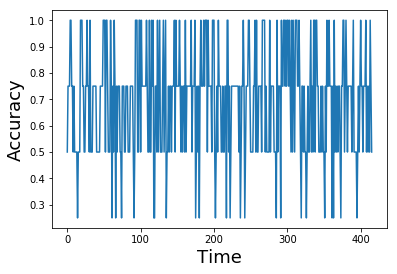

In [33]:
plot_line_graph(test.accuracy_list)

In [32]:
sched.shutdown() # shutdown the scheduler

Current Usage: [32.7130298 30.3404528 48.3735264 77.6361842]
Last expected Outputs:  [0, 0, 0, 1]
Last Predictions:  [0, -1, 0, 0]
Last Prediction Accuracy 0.5
Current Predictions:  [-1, -1, 0, 1] 



In [ ]:
print(sum(test.accuracy_list) / len(test.accuracy_list))

In [ ]:
mylist = np.array([cpuinfo()])
print(mylist)
print(mylist.shape)

In [ ]:
mylist2 = np.insert(mylist,0, np.array([cpuinfo()]), axis = 0)
print(mylist2)

In [ ]:
mylist = np.append(np.empty(shape = (0,5)), np.array([cpuinfo()]), axis = 0)
print(mylist)
print(mylist.shape)

In [ ]:
mylist[:,1]

In [ ]:
a = [1,2,3,4]
a[1:]
','.join(str(e) for e in a)
print("hey",a[:3])

In [ ]:
b = np.random.randint(1,100,size = (10,5))
b

In [ ]:
np.expand_dims(np.expand_dims(b[:,1],axis = 1),axis = 0).shape
#b[:,1]

In [ ]:
np.zeros(5)

In [ ]:
callAPIWithPredictions([0,0,0,0],"http://152.46.19.80:5000/changeVCPU")
cpuinfo()

In [34]:
print(sum(test.accuracy_list) / len(test.accuracy_list))

0.6941105769230769


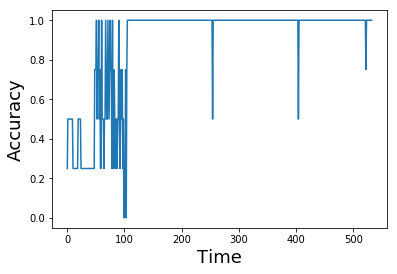

In [23]:
plot_line_graph(test.accuracy_list)

In [ ]:
RL3OutputDNNModel.summary()